In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!sudo apt-get install python-numpy gdal-bin libgdal-dev
!pip install rasterio

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-numpy is already the newest version (1:1.13.3-2ubuntu1).
python-numpy set to manually installed.
gdal-bin is already the newest version (2.2.3+dfsg-2).
libgdal-dev is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
     |████████████████████████████████| 19.1MB 1.1MB/s 


In [ ]:
dataset_dir='/content/gdrive/My Drive/ISPRS_semantic_labeling_Vaihingen/'
train_x_path='/content/gdrive/My Drive/ISPRS_semantic_labeling_Vaihingen/top1'
train_y_path='/content/gdrive/My Drive/ISPRS_semantic_labeling_Vaihingen/gts1'
test_x_path='/content/gdrive/My Drive/ISPRS_semantic_labeling_Vaihingen/top2'
test_y_path='/content/gdrive/My Drive/ISPRS_semantic_labeling_Vaihingen/gts2'

In [ ]:
import rasterio
def reading_image(path):
  src = rasterio.open(path)
  array = src.read()
  return array

In [ ]:
def convert_gt_binary(building_gt):
  return np.where(building_gt>0.8,1.0,0.0)

In [ ]:
import cv2
def resiz(building_gt):
  dim=(512,512)
  resized = cv2.resize(building_gt, dim, interpolation = cv2.INTER_AREA)
  return resized

In [ ]:

from torch.utils.data import Dataset
from torchvision import transforms
from natsort import natsorted
import os
import numpy as np


class BRATSDataset2D(Dataset):

    def __init__(self, input_path,gt_path, transform=None,binarise=True):
        input_paths=[os.path.join(input_path,folder) for folder in os.listdir(input_path) ]
        input_paths=natsorted(input_paths)
        label_paths=[os.path.join(gt_path,folder) for folder in os.listdir(gt_path) ]
        label_paths=natsorted(label_paths)
        #input_paths=[read_input_paths(subfolder)  for subfolder in subfolders]
        #label_paths=[read_label_paths(subfolder)  for subfolder in subfolders]
        self.binarise=True
        self.datastore = []
        for inps,lbl in zip(input_paths,label_paths):
          #im_inps=np.asarray(np.load(inps)) #for x in inps])
          #labels=np.asarray([np.load(y) for y in lbl])
          #for i in range(im_inps.shape[0]):
            #slc = im_inps[...,i]
            #slc = im_inps[i,:,:,:]
            #if slc.min() == 0 and slc.max() == 0:
            #  continue
            #datum = (inps, lbl, i)
            
            datum = (inps, lbl)
            self.datastore.append(datum)

        self.transform = transform

    def __len__(self):
        return len(self.datastore)

    def __getitem__(self, idx):
      datum = self.datastore[idx]
      
      im_inps=reading_image(datum[0])###########Reading tif image with rasterio
      im_inps=np.transpose(im_inps,(1,2,0))
      im_inps=resiz(im_inps)                  ######Resizing input image
      im_inps=np.transpose(im_inps,(2,0,1))
      im_inps=im_inps/np.max(im_inps)         #######Normalizing input
      #im_inps=(im_inps-0.3605692566298038)/0.18194970820847367
      labels=reading_image(datum[1])#np.asarray(np.load(datum[1]))# for y in lbl])
      
      labels=resiz(labels[1])
      labels=convert_gt_binary(np.squeeze(labels))#######preparing gt for only buildings
      
      
      return im_inps, labels 

In [ ]:
def plot_bi1(inpt,ori_imgs,  figsize = (5, 5)):
    IMG_SIZE=512
    print()
    fig, axes = plt.subplots(1, 2, figsize = figsize)
    fig.subplots_adjust(hspace=0.4, wspace = 0.4, right =0.7)
    
    axes[0].imshow(inpt)
    axes[0].set_xlabel('inp')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[1].imshow(ori_imgs)#np.reshape(recon_imgs,[IMG_SIZE, IMG_SIZE]))
    axes[1].set_xlabel('mask')
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    
   

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


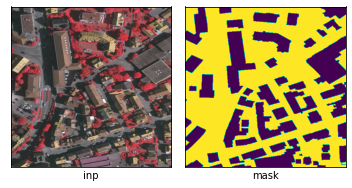

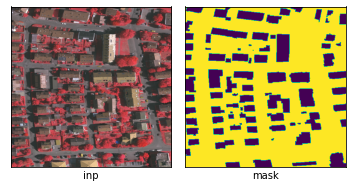

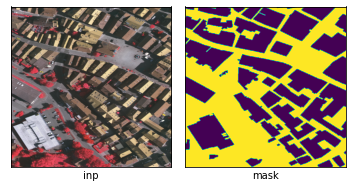

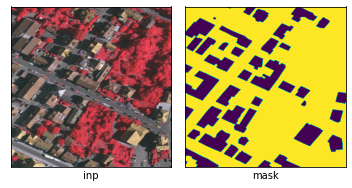

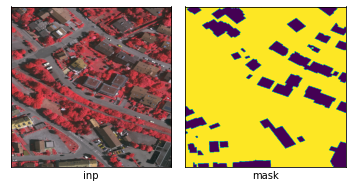

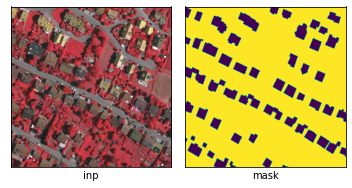

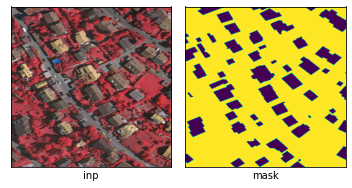

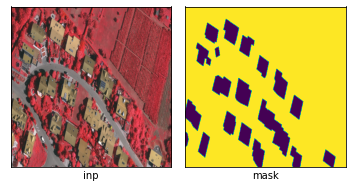

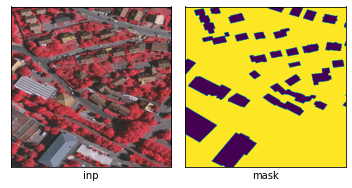

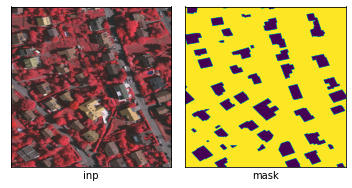

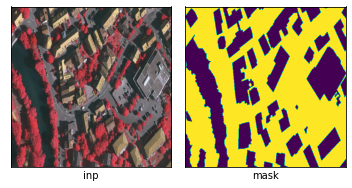

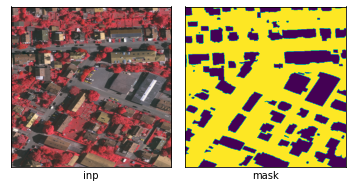

In [ ]:
import matplotlib.pyplot as plt

my_dataset = BRATSDataset2D(input_path=train_x_path,gt_path=train_y_path,binarise=True)
mean1=0.0
std1=0.0
for e1,e2 in my_dataset:
  #mean1+=np.mean(e1)
  #std1+=np.std(e1)
  #print(mean1/12,std1/12)
  e1=np.transpose(e1,(1,2,0))
  plot_bi1(e1,e2)


In [ ]:
print(len(my_dataset))
im=my_dataset[1][0]
print(im.shape)
im=(im-0.3605692566298038)/0.18194970820847367
print(np.mean(im),np.std(im))
print(np.max(im),print(np.min(im)))

12
(3, 512, 512)
0.03339281730637498 0.9078126070386475
-1.6584018198715988
3.514326841555314 None


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
!pip install tensorboardX

     |████████████████████████████████| 122kB 13.0MB/s 


In [ ]:
!pip install nibabel

In [ ]:
import tensorflow as tf
from tensorflow import summary
import datetime,json
import string

%load_ext tensorboard
current_time=str(datetime.datetime.now().timestamp())
train_log_dir='logs/tensorboard/train'+current_time
test_log_dir='logs/tensorboard/test'+current_time
train_summary_writer=summary.create_file_writer(train_log_dir)
test_summary_writer=summary.create_file_writer(test_log_dir)

In [ ]:
'''
@tf.function
def my_func(step,loss):
  with train_summary_writer.as_default():
    tf.summary.scalar("loss",loss,step)
'''

'\n@tf.function\ndef my_func(step,loss):\n  with train_summary_writer.as_default():\n    tf.summary.scalar("loss",loss,step)\n'

In [ ]:
import os
from scipy.ndimage import zoom  # For resizing
#subfolders=[os.path.join(folder_path_fully,folder) for folder in os.listdir(folder_path_fully) ]

#print(subfolders)


In [ ]:
import numpy as np
import rasterio
#import nibabel as nib








In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#import torch_geometric.nn as pyg_nn
#import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

#import networkx as nx
import numpy as np
import torch
import torch.optim as optim
#from torchvision.datasets import MNIST
import multiprocessing

import numpy as np
import scipy as sp
from skimage.segmentation import slic, mark_boundaries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
NP_TORCH_FLOAT_DTYPE = np.float32
NP_TORCH_LONG_DTYPE = np.int64


In [ ]:
import torch
#import networkx as nx

%matplotlib inline

In [ ]:

def dice_loss(input, target):
    """ This is a normal dice loss function for binary segmentation.
    Args:
        input: output of the segmentation network
        target: ground truth label
    Returns:
        dice score
    """
    smooth = 1
    #input = F.softmax(input, dim=1)
    # input = torch.sigmoid(input) #for binary
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    union = iflat.sum() + tflat.sum()
    dice_score = (2.*intersection + smooth)/(union + smooth)
    return 1-dice_score

class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        #predict=F.softmax(predict, dim=1)
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))


class DiceLoss(nn.Module):
    """Dice loss, need one hot encode input
    Args:
        weight: An array of shape [num_classes,]
        ignore_index: class index to ignore
        predict: A tensor of shape [N, C, *]
        target: A tensor of same shape with predict
        other args pass to BinaryDiceLoss
    Return:
        same as BinaryDiceLoss
    """
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index
        self.dice = BinaryDiceLoss(**self.kwargs)

    def forward(self, predict, target):
        assert predict.shape == target.shape, 'predict & target shape do not match'

        total_loss = 0
        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weights[i]
                total_loss += dice_loss

        return total_loss/target.shape[1]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#import torch_geometric.nn as pyg_nn
#import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

#import networkx as nx
import numpy as np
import torch
import torch.optim as optim
#from torchvision.datasets import MNIST
import multiprocessing

import numpy as np
import scipy as sp
from skimage.segmentation import slic, mark_boundaries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
NP_TORCH_FLOAT_DTYPE = np.float32
NP_TORCH_LONG_DTYPE = np.int64


In [ ]:
import torch
#import networkx as nx

%matplotlib inline

In [ ]:
from tensorboardX import SummaryWriter
writer = SummaryWriter(logdir='/content/runs')
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import pdb
import torch
import torch.nn as nn

from torch.nn.functional import softmax


class CNNfeaturemap(torch.nn.Module):
  def __init__(self):
        super(CNNfeaturemap, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1,padding=1)
        #self.maxpool1=nn.MaxPool2d(3, stride=2,padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1,padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1,padding=1)
        self.conv6 = nn.Conv2d(128, 256, 3, stride=1,padding=1)
        #self.maxpool2=nn.MaxPool2d(3, stride=2,padding=1)
        self.conv7 = nn.Conv2d(256, 1024, 3, stride=1,padding=1)
        
        #self.layernorm=nn.LayerNorm([14, 14])
        #self.layernorm1=nn.LayerNorm([7, 7])
        #self.layernorm2=nn.LayerNorm([7, 7])

  def forward(self, x):
        #print(torch.max(x))
        x1 = F.leaky_relu(self.conv1(x),0.2)#F.leaky_relu(self.maxpool1(self.conv1(x)),0.2)#F.leaky_relu(self.conv1(x))
        #x1=self.layernorm(x1)
        x2 = F.leaky_relu(self.conv2(x1),0.2)
        x3 = F.leaky_relu(self.conv3(x2),0.2)
        #x4 = F.leaky_relu(self.conv1(x3))
        
        #x6 = F.leaky_relu(self.maxpool2(self.conv6(x1)),0.2)#F.relu(self.conv6(x1))
        x6 = F.leaky_relu(self.conv6(x3),0.2)#F.relu(self.conv6(x1))
        #x6=self.layernorm1(x6)
        x7 = F.leaky_relu(self.conv7(x6),0.2)
        #x7=self.layernorm2(x7)

        #print('torch_max',torch.max(x7))
               
        return x7




class Encoder(torch.nn.Module):                        ######### aim is to create feature vector for GNN
  def __init__(self):                                  ###### Basic AE advanced VAE
        super(Encoder, self).__init__()                ###### Adaptive average pooling  and then flattened vector should be the output
        self.conv1 = nn.Conv2d(1024, 512, 3, stride=1,padding=1)
        self.conv2 = nn.Conv2d(512, 128, 3, stride=1,padding=1)
        self.conv5 = nn.Conv2d(128, 6, 3, stride=1,padding=1)
        self.conv6 = nn.Conv2d(6, 6, 3, stride=1,padding=1)
        self.conv7 = nn.Conv2d(6, 6, 1, stride=1)
  def reparameterize(self, mu, log_var):
        #std = logvar.mul(0.5).exp_()
        std=torch.exp(0.5*log_var)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
  def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
  def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]
        

  def forward(self, x):
        x1 = F.leaky_relu(self.conv1(x),0.2)
        #print(x1.size())
        x2 = F.leaky_relu(self.conv2(x1),0.2)
        
        x5 = F.leaky_relu(self.conv5(x2),0.2)
        #print(torch.max(x5))
        x6=torch.nn.AdaptiveAvgPool2d(32)(x5)
        
        feat=torch.nn.Flatten()(x6)
        mu = torch.nn.Flatten()(self.conv6(x6))
        logvar = torch.nn.Flatten()(self.conv7(x6))
        z=self.reparameterize(mu, logvar)

        return z,feat,mu,logvar

class Decoder(torch.nn.Module):            ######### aim is to create Adjacency matrix and Feature vector
  def __init__(self ):                     ###### inner product is adjacency matrix
        super(Decoder, self).__init__()   

  def gamma(A):
    gam=1+49/(torch.sum(A)+10e-7)    
    gam=gam.pow(0.5)    
    A1=A+gam*torch.diag(A)        
    return gam,A1
  
  def forward(self, x):
        A=x@x.t()
        gam=1+49/(torch.sum(A)+10e-7)    #################
        gam=gam.pow(0.5)                  ###########         Creating adaptive factor gamma
        A1=A+gam*torch.diag(A)           #########adding adaptive enhancement to adjacency matrix

        return gam,A1,x
#p=torch.zeros((1,1024,7,7))
#a,b,c,d=Encoder()(p)
#print(a.size())
#a,b,c,d=Encoder()(p)
#print(ad.size(),xt.size())



class GINConv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear = torch.nn.Linear(6, 6)
        self.linear1=torch.nn.Linear(6, 6)

    def forward(self, A, X):
        """
        Params
        ------
        A [batch x nodes x nodes]: adjacency matrix
        X [batch x nodes x features]: node features matrix
        
        Returns
        -------
        X' [batch x nodes x features]: updated node features matrix
        """
        X = self.linear(X + A @ X )#+ A**2 @ X)
        X1 = F.leaky_relu(X,0.2)
        X2=self.linear1(X1 + A @ X1)
        gam=1+49/(torch.sum(A)+10e-7)    #################
        gam=gam.pow(0.5) 
        z_sum_opt=gam*X1+X2
        
        return z_sum_opt
def dice_loss(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return 1 - (numerator + 1) / (denominator + 1)#1 - (numerator + 1) / (denominator + 1)
def kld_loss(mu,logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD
def kdl_loss(gamm,A):
  kdl1=-gamm/49*49
  kdl=kdl1*torch.sum(torch.log(torch.clamp(A, min=0, max=1)+10e-7))
  return kdl
class SCG(torch.nn.Module):
    def __init__(self,cnnfeaturemap,encoder,decoder,gin):
        super(SCG, self).__init__()
        self.cnnfeaturemap=cnnfeaturemap#CNNfeaturemap()
        self.encoder=encoder#Encoder()
        self.decoder=decoder#Decoder()
        self.gin=gin#GINConv()
        self.conv1=nn.Conv2d(6, 6, 3, stride=1,padding=1)
        self.upsample1=torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample2=torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample3=torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample4=torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample5=torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample6=torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample7=torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.upsample8=torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.conv2=nn.Conv2d(6, 6, 3, stride=1,padding=1)
        #self.layernorm=nn.LayerNorm([28, 28])
        self.conv3=nn.Conv2d(6, 36, 3, stride=1,padding=1)
        self.conv4=nn.Conv2d(36, 128, 3, stride=1,padding=1)
        self.conv5=nn.Conv2d(128, 256, 3, stride=1,padding=1)
        self.conv6=nn.Conv2d(256, 512, 3, stride=1,padding=1)
        self.conv7=nn.Conv2d(512, 1024, 3, stride=1,padding=1)
        self.conv8=nn.Conv2d(1024, 512, 3, stride=1,padding=1)
        self.conv9=nn.Conv2d(512, 256, 3, stride=1,padding=1)
        self.conv10=nn.Conv2d(256, 128, 3, stride=1,padding=1)
        self.conv11=nn.Conv2d(128, 36, 3, stride=1,padding=1)
        self.conv12=nn.Conv2d(36, 6, 3, stride=1,padding=1)
        self.conv13=nn.Conv2d(6, 1, 3, stride=1,padding=1)
        self.layernorm1=nn.LayerNorm([512, 512])

        

    def forward(self, x):
        cnf=self.cnnfeaturemap(x)
        #print('cnf',cnf.size())
        z,feat,mu,logvar=self.encoder(cnf)
        #enc1=enc.squeeze()
        #print(z.size())
        z=torch.reshape(z,(32*32,6))
        gam,adj,featurematrix=self.decoder(z)
        #print(adj.size(),featurematrix.size())
        fmatrix=self.gin(adj,featurematrix)
        
        
        fmatrix=torch.reshape(fmatrix,(1,6,32,32))
        fmatrix=self.conv1(fmatrix)
        fmatrix1=F.leaky_relu(fmatrix,0.2)
        #z1=mu*(1-logvar)                                                ########### residual term as per paper
        #z1=z1*gam                                                       ########## adaptive enhancement gam is added to residual z1
        #fmatrix1=nn.Flatten()(fmatrix1)
        fmatrix1 = fmatrix1.view(-1)
        #zf=z1+fmatrix1
        zf=fmatrix1
        zf=torch.reshape(zf,(1,6,32,32))
        zf=self.upsample1(zf)
        fmatrix2=self.conv2(zf)
        fmatrix2=F.leaky_relu(fmatrix2,0.2)
        
        #fmatrix2=self.layernorm(fmatrix2)
        fmatrix3=self.conv3(fmatrix2)
        fmatrix3=F.leaky_relu(fmatrix3,0.2)
        
        fmatrix4=self.conv4(fmatrix3)
        fmatrix4=F.leaky_relu(fmatrix4,0.2)
        fmatrix5=self.conv5(fmatrix4)
        fmatrix5=F.leaky_relu(fmatrix5,0.2)
        fmatrix6=self.conv6(fmatrix5)
        fmatrix6=F.leaky_relu(fmatrix6,0.2)
        fmatrix7=self.conv7(fmatrix6)
        fmatrix7=F.leaky_relu(fmatrix7,0.2)
        fmatrix8=self.conv8(fmatrix7)
        fmatrix8=F.leaky_relu(fmatrix8,0.2)
        fmatrix9=self.conv9(fmatrix8)
        
        fmatrix9=F.leaky_relu(fmatrix9,0.2)
        fmatrix9=self.upsample2(fmatrix9)
        fmatrix10=self.conv10(fmatrix9)
        
        fmatrix10=F.leaky_relu(fmatrix10,0.2)
        fmatrix10=self.upsample3(fmatrix10)
        #fmatrix10=self.conv10(fmatrix10)
        fmatrix11=self.conv11(fmatrix10)
        fmatrix11=F.leaky_relu(fmatrix11,0.2)
        fmatrix11=self.upsample4(fmatrix11)
        fmatrix12=self.conv12(fmatrix11)
        fmatrix12=F.leaky_relu(fmatrix12,0.2)
        #fmatrix12=self.upsample5(fmatrix12)
        fmatrix13=self.conv13(fmatrix12)
        #fmatrix13=F.leaky_relu(fmatrix13,0.2)
        fmatrix14=self.layernorm1(fmatrix13)
        fmatrix14=torch.reshape(fmatrix14,(1,1,512,512))
        
        #fmatrix2=nn.LogSoftmax(dim=1)(fmatrix2)
        
        fmatrix14=torch.sigmoid(fmatrix14)
        #fmatrix2=nn.Softmax(dim=1)(fmatrix2)

        return fmatrix14,mu,logvar,gam,adj,x,cnf,z,feat

In [ ]:
class Dice(nn.Module):
    """
    Class used to get dice_loss and dice_score
    """

    def __init__(self, smooth=1):
        super(Dice, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred_f = torch.flatten(y_pred)
        y_true_f = torch.flatten(y_true)
        intersection = torch.sum(y_true_f * y_pred_f)
        union = torch.sum(y_true_f + y_pred_f)
        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice_score
        return dice_loss
diceloss=Dice()

In [ ]:

from torch.utils.data import TensorDataset, DataLoader
 
cnnfeaturemap=CNNfeaturemap()
encoder=Encoder()
decoder=Decoder()
gin=GINConv()

model = SCG(cnnfeaturemap,encoder,decoder,gin)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" )



from torch.utils.data import TensorDataset, DataLoader
 


use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" )

my_dataset = BRATSDataset2D(input_path=train_x_path,gt_path=train_y_path,binarise=True)
train_loader = DataLoader(my_dataset,batch_size=1, shuffle=True)
test_dataset = BRATSDataset2D(input_path=test_x_path,gt_path=test_y_path,binarise=True)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=True)
writer = SummaryWriter()

model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
batch_size=4
trainingloss=[]
testloss=[]
iters=[]

train_input=[]
test_input=[]
train_pred=[]
test_pred=[]
train_gt=[]
test_gt=[]
train_iter_epoch=[]
test_iter_epoch=[]
test_losses=[]
train_losses = []
valid_losses = []
#loss_fn=BinaryDiceLoss()
#testloss=BinaryDiceLoss()
#model.cuda()

#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_losses = []
valid_losses = []
num_epochs=5000
for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    #scheduler.step()
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device).float()
        target = target.to(device).float()
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        #print(data.shape)
        #data=data.permute(0,3,1,2)
        outputtr,mu1,logvar1,gam1,adj1,x1,cnf1,z1,feat1 = model(data)
        # calculate-the-batch-loss
        loss=diceloss(outputtr,target)+0.0001*kld_loss(mu1,logvar1)#+kdl_loss(gamm,adj)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        #loss.backward()
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    model.eval()
    for data, target in test_loader:
        
        data = data.to(device).float()
        target = target.to(device).float()
        #data=data.permute(0,3,1,2)
        outputte,mu2,logvar2,gam2,adj2,x2,cnf2,z2,feat2 = model(data)
        
        loss=diceloss(outputte,target)+0.0001*kld_loss(mu2,logvar2)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(test_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))



/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Streaming output truncated to the last 5000 lines.
Epoch-2501 lr: 1e-05
Epoch: 2501 	Training Loss: 0.332404 	Validation Loss: 0.336511
Epoch-2502 lr: 1e-05
Epoch: 2502 	Training Loss: 0.332391 	Validation Loss: 0.336527
Epoch-2503 lr: 1e-05
Epoch: 2503 	Training Loss: 0.332376 	Validation Loss: 0.336416
Epoch-2504 lr: 1e-05
Epoch: 2504 	Training Loss: 0.332333 	Validation Loss: 0.336490
Epoch-2505 lr: 1e-05
Epoch: 2505 	Training Loss: 0.332255 	Validation Loss: 0.336465
Epoch-2506 lr: 1e-05
Epoch: 2506 	Training Loss: 0.332271 	Validation Loss: 0.336455
Epoch-2507 lr: 1e-05
Epoch: 2507 	Training Loss: 0.332272 	Validation Loss: 0.336436
Epoch-2508 lr: 1e-05
Epoch: 2508 	Training Loss: 0.332271 	Validation Loss: 0.336420
Epoch-2509 lr: 1e-05
Epoch: 2509 	Training Loss: 0.332284 	Validation Loss: 0.336483
Epoch-2510 lr: 1e-05
Epoch: 2510 	Training Loss: 0.332214 	Validation Loss: 0.336333
Epoch-2511 lr: 1e-05
Epoch: 2511 	Training Loss: 0.332192 	Validation Loss: 0.336343
Epoch-2512 lr:

In [ ]:
torch.save(model, '/content/gdrive/My Drive/scg_vae_weights_vaihingen.pt')

In [ ]:
#!pip install tensorboard

In [ ]:
#%tensorboard --logdir=runs

In [ ]:
'''
plt.plot(np.arange(50),trainingloss,label='Training loss')
#plt.show()
#plt.plot(np.arange(50),testloss,label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
'''
'''
plt.plot(np.arange(100),trainingloss,label='Training loss')
#plt.show()
plt.plot(np.arange(100),testloss,label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#test_loss
'''


"\nplt.plot(np.arange(100),trainingloss,label='Training loss')\n#plt.show()\nplt.plot(np.arange(100),testloss,label='Test loss')\nplt.xlabel('Epochs')\nplt.ylabel('Loss')\nplt.legend()\nplt.show()\n#test_loss\n"

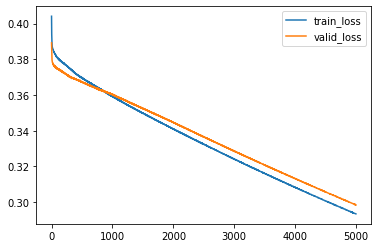

In [ ]:
plt.plot(train_losses)
plt.plot(valid_losses)

plt.legend(["train_loss", "valid_loss"])

In [ ]:
import logging
def plot_bi(inpt,ori_imgs, recon_imgs, figsize = (5, 5)):
    IMG_SIZE=512
    print()
    fig, axes = plt.subplots(1, 3, figsize = figsize)
    fig.subplots_adjust(hspace=0.4, wspace = 0.4, right =0.7)
    
    axes[0].imshow(np.transpose(inpt,(1,2,0)))
    axes[0].set_xlabel('inp')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[1].imshow(ori_imgs)#np.reshape(recon_imgs,[IMG_SIZE, IMG_SIZE]))
    axes[1].set_xlabel('mask')
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    axes[2].imshow(recon_imgs)#np.reshape(recon_imgs,[IMG_SIZE, IMG_SIZE]))
    axes[2].set_xlabel('mask')
    axes[2].set_xticks([])
    axes[2].set_yticks([])

   

    plt.tight_layout()
    plt.show()
def plot(ori_imgs, recon_imgs, masked_imgs,masked_imgs1, figsize = (10, 10)):
    IMG_SIZE=240
    print()
    fig, axes = plt.subplots(1, 4, figsize = figsize)
    fig.subplots_adjust(hspace=0.4, wspace = 0.4, right =0.7)
    
    axes[0].imshow(np.reshape(ori_imgs,[IMG_SIZE, IMG_SIZE]), cmap = 'gray')
    axes[0].set_xlabel('channel 0')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[1].imshow(np.reshape(recon_imgs,[IMG_SIZE, IMG_SIZE]), cmap = 'gray')
    axes[1].set_xlabel('channel 2')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    axes[2].imshow(np.reshape(masked_imgs,[IMG_SIZE, IMG_SIZE]), cmap = 'gray')
    axes[2].set_xlabel('Channel 3')
    axes[2].set_xticks([])
    axes[2].set_yticks([])

    
    
    plt.tight_layout()
    plt.show()

def plot_testoutputs(test_input,test_pred,test_gt):
    #for each in range(200):
        
      inpti=test_input#[1]
      predti=test_pred#[1]
      gtti=test_gt#[1]
      #print('epoch no :',test_iter_epoch[each])
      
      #print('input',inpti.shape)
      #print('pred',predti.shape)
      #print('gt',gtti.shape)
      
      inpti=inpti.squeeze().cpu().detach().numpy()
      predti=predti.squeeze().cpu().detach().numpy()
      gtti=gtti.squeeze().cpu().detach().numpy()
      #predti=predti.squeeze().cpu().detach().numpy()
      print('dice_loss:',dice(predti,gtti))
      #print(predt1.shape)
      #predti=predti.numpy()
      #print(predti.shape)
      
      
      if (predti.min() <= 0 and predti.max() <= 0) or (predti.min()==predti.max()) :
          predti[predti<=0] = 0
          #plot1(inpti[0],inpti[1],inpti[2],inpti[3])
          colur_maski=create_diff_mask_binary(predti, gtti)
      
          plot_bi(inpti,predti,colur_maski)
          
      else:
        thresh = threshold_otsu(predti)
        predti[predti<=thresh] = 0
        predti[predti>thresh] = 1
        #plot1(inpti[0],inpti[1],inpti[2],inpti[3])
        colur_maski=create_diff_mask_binary(predti, gtti)
      
        plot_bi(inpti,predti,colur_maski)
class Logger:
    def __init__(self, model_name, logger_path):
        self.logger = logging.getLogger(model_name)
        hdlr = logging.FileHandler(logger_path)
        formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
        hdlr.setFormatter(formatter)
        self.logger.addHandler(hdlr)
        self.logger.setLevel(logging.DEBUG)

    def get_logger(self):
      return self.logger

from skimage.filters import threshold_otsu
def create_mask(predicted):
    """
    Method find the difference between the 2 images and overlay colors
    predicted, label : slices , 2D tensor
    """
    predicted = predicted.cpu().data.numpy()

    
    thresh = threshold_otsu(predicted)
    predicted_binary = predicted > thresh
    #except Exception as error:
    #    logger.exception(error)
    predicted_binary = predicted > 0.5  # exception will be thrown only if input image seems to have just one color 1.0.

    # Define colors
    black = np.array([0, 0, 0], dtype=np.uint8)  # background
    white = np.array([255, 255, 255], dtype=np.uint8)  # prediction_output

    # Make RGB array, pre-filled with black(background)
    rgb_image = np.zeros((predicted_binary.shape[0], predicted_binary.shape[1], 3), dtype=np.uint8) + black

    # Overwrite with red where threshold exceeded, i.e. where mask is True
    rgb_image[predicted_binary] = white

    return rgb_image

def create_diff_mask(predicted, label):
    """
    Method find the difference between the 2 images(predicted being grescale, label being binary) and overlay colors
    predicted, label : slices , 2D tensor
    """
    label = label.cpu().data.numpy()
    predicted = predicted.cpu().data.numpy()

    
    thresh = threshold_otsu(predicted)
    predicted_binary = predicted > thresh
    #except Exception as error:
    #    logger.exception(error)
    predicted_binary = predicted > 0.5  # exception will be thrown only if input image seems to have just one color 1.0.

    # fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
    # ax = axes.ravel()
    # ax[0] = plt.subplot(1, 3, 1)
    # ax[1] = plt.subplot(1, 3, 2)
    # ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])
    #
    # ax[0].imshow(predicted, cmap=plt.cm.gray)
    # ax[0].set_title('Original')
    # ax[0].axis('off')
    #
    # ax[1].hist(predicted.ravel(), bins=256)
    # ax[1].set_title('Histogram')
    # ax[1].axvline(thresh, color='r')
    #
    # ax[2].imshow(predicted_binary, cmap=plt.cm.gray)
    # ax[2].set_title('Thresholded')
    # ax[2].axis('off')
    #
    # plt.show()

    diff1 = np.subtract(label, predicted_binary) > 0
    diff2 = np.subtract(predicted_binary, label) > 0

    # Define colors
    red = np.array([255, 0, 0], dtype=np.uint8)  # under_detected
    green = np.array([0, 255, 0], dtype=np.uint8)  # over_detected
    black = np.array([0, 0, 0], dtype=np.uint8)  # background
    white = np.array([255, 255, 255], dtype=np.uint8)  # prediction_output
    blue = np.array([0, 0, 255], dtype=np.uint8) # over_detected
    yellow = np.array([255, 255, 0], dtype=np.uint8)  # under_detected

    # Make RGB array, pre-filled with black(background)
    rgb_image = np.zeros((predicted_binary.shape[0], predicted_binary.shape[1], 3), dtype=np.uint8) + black

    # Overwrite with red where threshold exceeded, i.e. where mask is True
    rgb_image[predicted_binary] = white
    rgb_image[diff1] = red
    rgb_image[diff2] = blue

    return rgb_image

def create_diff_mask_binary(predicted, label):
    """
    Method find the difference between the 2 binary images and overlay colors
    predicted, label : slices , 2D tensor
    """
    predicted_label = label#.cpu().data.numpy()
    predicted_binary = predicted#.cpu().data.numpy()

    diff1 = np.subtract(predicted_label, predicted_binary) > 0
    diff2 = np.subtract(predicted_binary, predicted_label) > 0

    predicted_binary = predicted_binary > 0

    # Define colors
    red = np.array([255, 0, 0], dtype=np.uint8)  # under_detected
    green = np.array([0, 255, 0], dtype=np.uint8)  # over_detected
    black = np.array([0, 0, 0], dtype=np.uint8)  # background
    white = np.array([255, 255, 255], dtype=np.uint8)  # prediction_output
    blue = np.array([0, 0, 255], dtype=np.uint8) # over_detected
    yellow = np.array([255, 255, 0], dtype=np.uint8)  # under_detected

    # Make RGB array, pre-filled with black(background)
    rgb_image = np.zeros((predicted_binary.shape[0], predicted_binary.shape[1], 3), dtype=np.uint8) + black

    # Overwrite with red where threshold exceeded, i.e. where mask is True

    #predicted_binary=np.transpose(predicted_binary, (1, 0, 2))
    rgb_image[predicted_binary] = white
    rgb_image[diff1] = red
    rgb_image[diff2] = blue
    return rgb_image



def show_diff(label, predicted, diff_image):
    '''
   Method to display the differences between label, predicted and diff_image
   '''
    fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
    ax = axes
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(label, cmap=plt.cm.gray)
    ax[0].set_title('GroundTruth')
    ax[0].axis('off')

    ax[1].imshow(predicted, cmap=plt.cm.gray)
    ax[1].set_title('Predicted')
    ax[0].axis('off')

    ax[2].imshow(diff_image, cmap=plt.cm.gray)
    ax[2].set_title('Difference image')
    ax[2].axis('off')

    plt.show()
def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())
def plot1(ori_imgs, recon_imgs, masked_imgs,masked_imgs1, figsize = (10, 10)):
    IMG_SIZE=192
    print()
    
    fig, axes = plt.subplots(1, 4, figsize = figsize)
    fig.subplots_adjust(hspace=0.4, wspace = 0.4, right =0.7)
    
    axes[0].imshow(np.reshape(ori_imgs,[IMG_SIZE, IMG_SIZE]), cmap = 'gray')
    axes[0].set_xlabel('channel 0')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[1].imshow(np.reshape(recon_imgs,[IMG_SIZE, IMG_SIZE]), cmap = 'gray')
    axes[1].set_xlabel('channel 2')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    axes[2].imshow(np.reshape(masked_imgs,[IMG_SIZE, IMG_SIZE]), cmap = 'gray')
    axes[2].set_xlabel('Channel 3')
    axes[2].set_xticks([])
    axes[2].set_yticks([])

    axes[3].imshow(np.reshape(masked_imgs1,[IMG_SIZE, IMG_SIZE]), cmap = 'gray')
    axes[3].set_xlabel('Channel 4')
    axes[3].set_xticks([])
    axes[3].set_yticks([])
    
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


accuracy tensor(0., device='cuda:0')
dice_loss: 0.8775223141168235



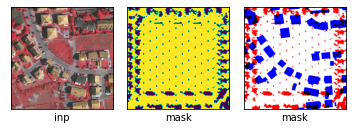

accuracy tensor(0., device='cuda:0')
dice_loss: 0.8576782208742676



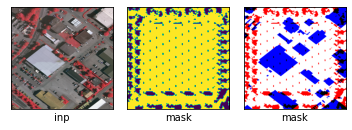

accuracy tensor(0., device='cuda:0')
dice_loss: 0.8623580084842304



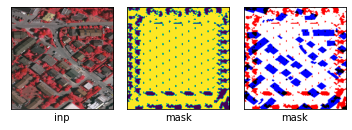

accuracy tensor(0., device='cuda:0')
dice_loss: 0.8618467897396711



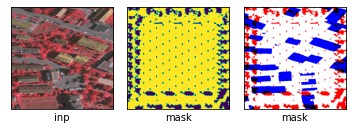

In [ ]:
#model = torch.load('/content/gdrive/My Drive/scg_vae_weights_vaihingen.pt')

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" )

#my_dataset = BRATSDataset2D(root_path=folder_path_fully,binarise=True)
#my_dataloader = DataLoader(my_dataset,batch_size=1, shuffle=True)

test_dataset = BRATSDataset2D(input_path=test_x_path,gt_path=test_y_path,binarise=True)
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=True)
writer = SummaryWriter()

model.cuda()

#optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
batch_size=1
trainingloss=[]
testloss=[]
iters=[]

train_input=[]
test_input=[]
train_pred=[]
test_pred=[]
train_gt=[]
test_gt=[]
train_iter_epoch=[]
test_iter_epoch=[]
test_losses=[]
loss_fn=Dice()
testloss=Dice()



    
  
with torch.no_grad():
    model.eval()
        
    test_losses=[]
    for images,labels in test_loader:
      if (torch.min(images) == 0 and torch.max(images) == 0)  :
          continue
      #images=data_transform(images)
      images=images.cuda().float()
      #images=images.permute(0,3,1,2)
      #print(images.shape)   
      outputtest,mut,logvart,gamt,adjt,xt,cnft,zt,featt = model(images)
        
          #test_loss = dice_loss(outputs.cuda(), labels.cuda())
          
          #test_loss=testloss(outputs, labels.cuda())
          #test_losses.append(float(test_loss))
      #print(images.shape)
      #print(outputs.shape)
      #print(labels.shape)
      print('accuracy',acc_metric(outputtest,images))
      plot_testoutputs(images,outputtest,labels)
      test_input.append(images)
      test_pred.append(outputtest)
      test_gt.append(labels)
         